# GPMol overview

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'/home/beangoben/projects/gpmol')

In [12]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline
#%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Century Gothic"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['text.usetex'] = False 
plt.rcParams['mathtext.rm'] = "Century Gothic"
plt.rcParams['mathtext.it'] = "Century Gothic:italic"
plt.rcParams['mathtext.bf'] = "Century Gothic:bold"
plt.rcParams['axes.unicode_minus'] =  False

In [3]:
from IPython.display import display
import math

import numpy as np
import pandas as pd
import gpmol as gpm
from gpmol.utils.plotting import *

gpm.logging.set_level('warning')
gpm.plot_settings()
gpm.pandas_settings()

Running in Jupyter notebook 


# Traing PM7+GP rxn calibration
## Data labels

In [4]:
calc_type = 'PM7'
target='ORP_exp'
baseline ='ORP_{}'.format(calc_type)
linfit ='ORP_PM7linfit'
diff_label= 'ORP_diff'
calib_label='ORP_PM7GP'

## Load a Dataset

In [5]:
df = pd.read_csv('data/redox_calibration.csv')
features=[target,baseline,'category','KEGG_ID2','smiles_r','smiles_l']
linear_fit = np.poly1d(np.polyfit(df[baseline],df[target],1))
df[linfit]=linear_fit(df[baseline])
df[diff_label]=df[target]-df[linfit]
print(df.shape)
df.head()

(80, 13)


,KEGG_ID1,KEGG_ID2,category,ORP_exp,KEGG_l,KEGG_r,smiles_r,smiles_l,ORP_GCM,ORP_PM7,ORP_DLPNO,ORP_PM7linfit,ORP_diff
0,C00280 + C00282 = C00535,C00280 = C00535,2,-318,['C00280'],['C00535'],C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@]34C)[C@...,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@]34C)[C@...,-293.25,-866.22,nan,-238.51,-79.49
1,C00468 + C00282 = C00951,C00468 = C00951,2,-308,['C00468'],['C00951'],C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1CC...,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1CC...,-293.25,-833.86,-44.26,-233.72,-74.28
2,C00207 + C00282 = C01845,C00207 = C01845,2,-295,['C00207'],['C01845'],CC(C)O,CC(C)=O,-219.05,-943.17,-11.79,-249.90,-45.10
3,C00414 + C00282 = C00854,C00414 = C00854,2,-289,['C00414'],['C00854'],OC1CCCCC1,O=C1CCCCC1,-293.25,-895.41,5.70,-242.83,-46.17
4,C03067 + C00282 = C03351,C03067 = C03351,2,-285,['C03067'],['C03351'],OCc1cccc(O)c1,Oc1cccc(C=O)c1,-206.31,-684.67,21.76,-211.64,-73.36


## Create preprocessor pipeline

In [6]:
from gpmol.features import RegressionTarget, RxnFP, Properties
from gpmol.data_transforms import SMILES2MOL

preproc = gpm.Preprocessor(df)
preproc.append([
    SMILES2MOL('smiles_r','mol_r'),
    SMILES2MOL('smiles_l','mol_l'),
    RegressionTarget(col_labels=diff_label,units='mV'),
    RxnFP(cols=['mol_r','mol_l'],rxnfp_type='diff',fp_type='count-morgan',fp_args={'nBits': 2048, 'radius': 6})
])

,Name,Type,cols,n_dim,preprocessing,GP,Meta-data
0,ORP_diff,Regression,ORP_diff,1,Standardize,likelihood = Gaussian,units = mV
1,RxnFP,RxnFP,mol_r/mol_l,103,,kernel = RBF,"fp_args = {'nBits': 2048, 'radius': 6}, fp_typ..."


## Optimize hyperparameters

Instructions for updating:
Colocations handled automatically by placer.
From /home/beangoben/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer. 
Shape of x must be 2D at computation. 
Instructions for updating:
Use tf.cast instead.
From /home/beangoben/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3068: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead. 
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
From /home/beangoben/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is 

Adam:   2%|▏         | 249/10000 [00:01<01:07, 143.77it/s, ll=-9.30e+01, Δ=9.92e-04]


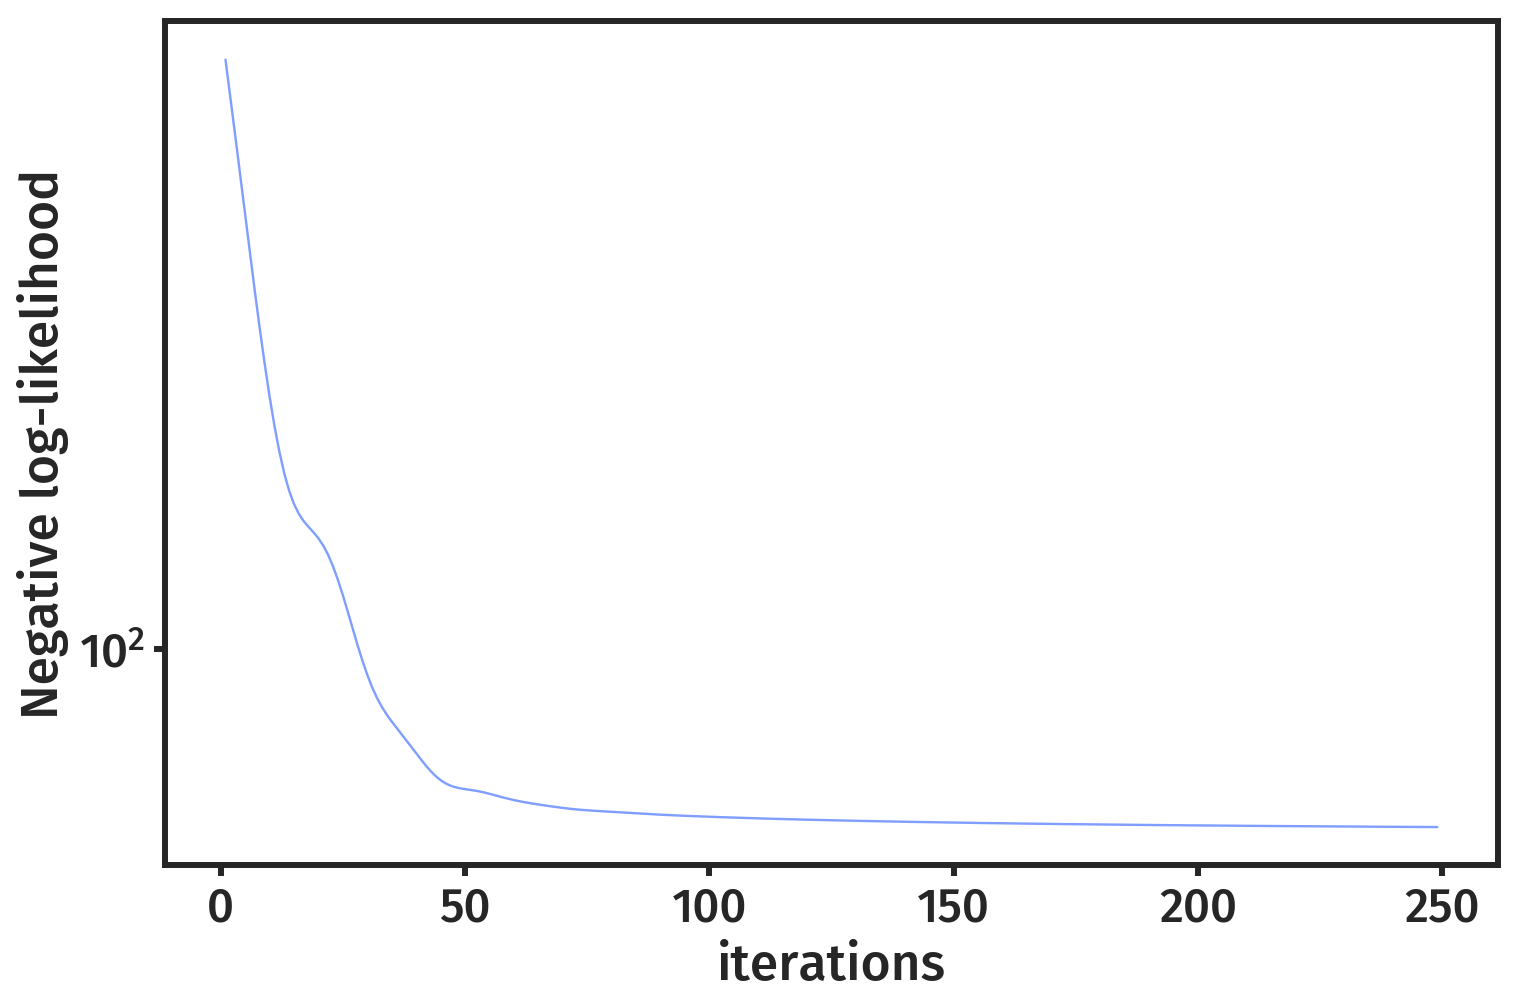

Regression task for ORP_diff

* X shape: (80, 103)
* Y shape: (80, 1)
* Log-likelihood = -93.030947
* Kernel  (3 hyper-parameters)
	0. White Noise
		* variance        = 0.0690
	1. RBF kernel, RxnFP, 103 dims
		* variance        = 4.2917
		* lengthscales    = 4.7493

In [7]:
gp = preproc.make_gpmol()
gp.minimize()
gp.plot_training_curve()
plt.show()
gp

## Extra: CV-Results

In [8]:
cv_results = gp.cross_validate()
cv_results.update(gp.comparison_suite())
cv_df = gp.summary_results(cv_results,set_tag='CV',trim=True,save=True)
cv_df

Shape of x must be 2D at computation. 


CV: 100%|██████████| 80/80 [14:55<00:00, 25.76s/it]


MAE  AE ($\sigma$)  RMSE    r  $R^2$
Task       Set Target   Approach                                          
Regression CV  ORP_diff GP          21.93          18.84 28.92 0.68   0.45
                        KernelRidge 25.30          19.03 31.66 0.59   0.34
                        Lasso       31.18          25.21 40.10 0.20  -0.05
                        SVR         29.71          25.38 39.08 0.12   0.00

## Extra: calibration

In [10]:
df[calib_label]=df[linfit]+cv_results['GP_pred'].flatten()
df[calib_label+'_std']=df[linfit]+cv_results['GP_std'].flatten()

## Extra: comparison

/home/beangoben/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/home/beangoben/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/home/beangoben/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


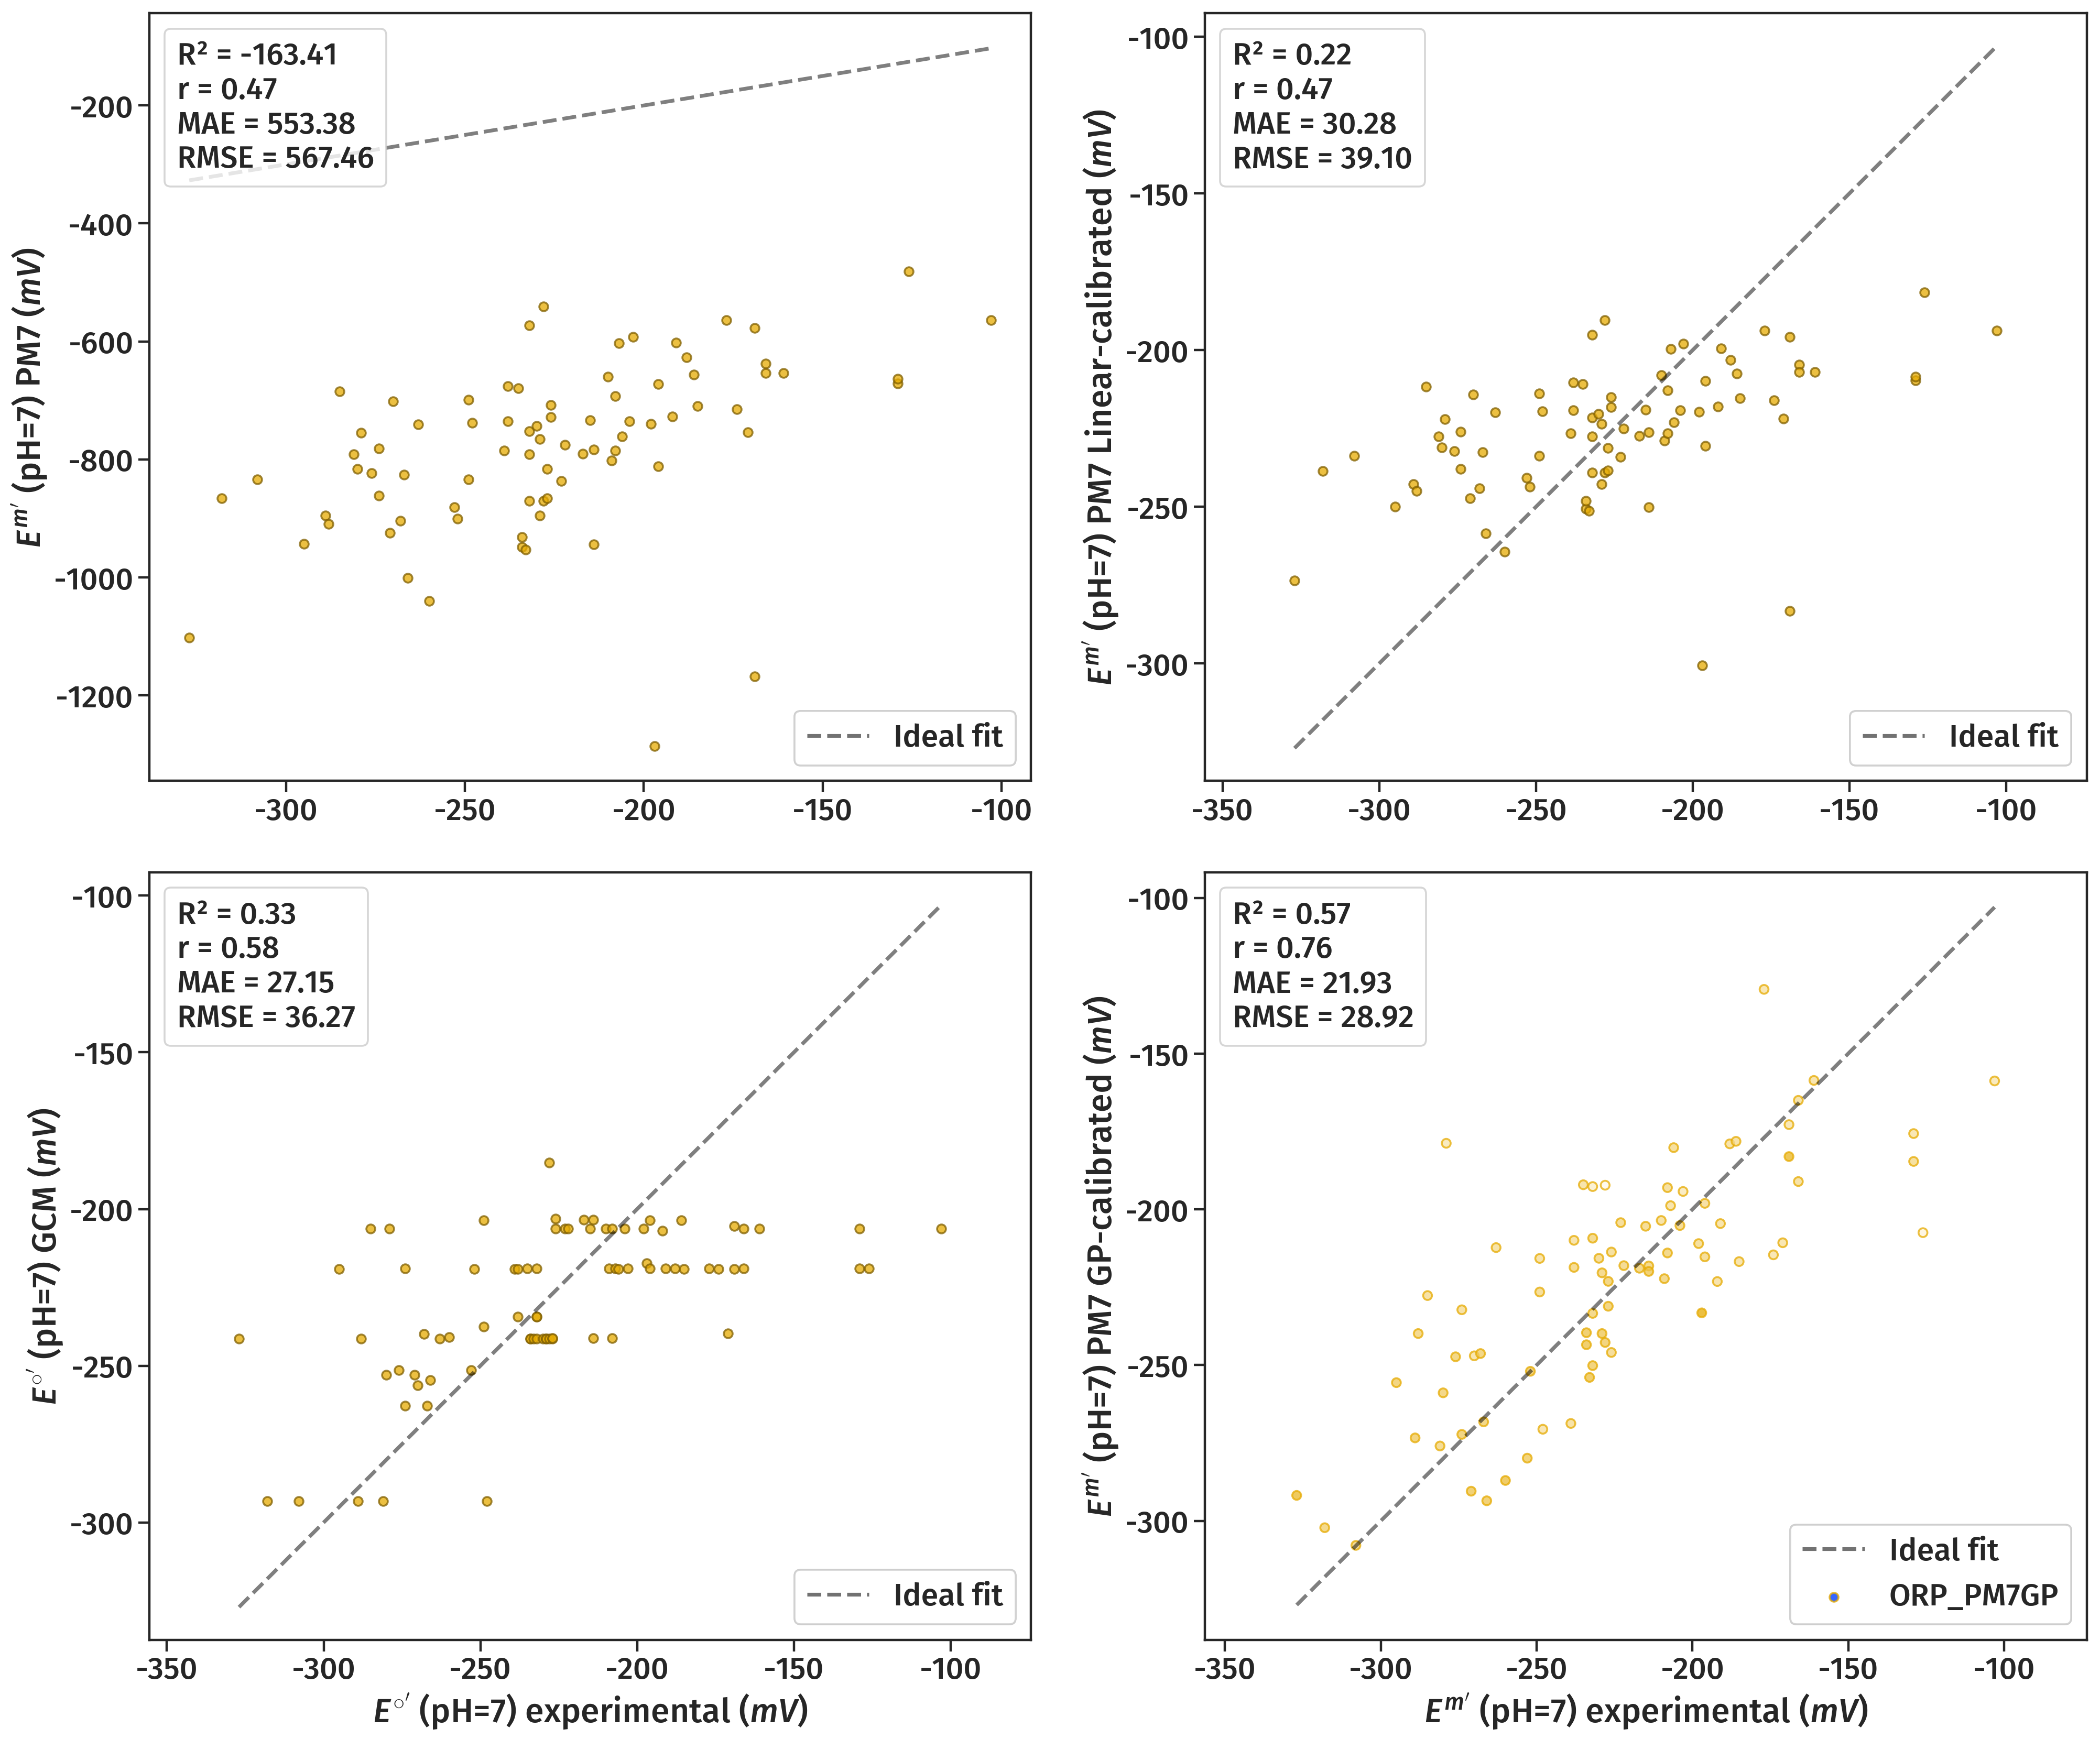

In [11]:
#awe.plot_settings()
col=gp.cols[diff_label]
cmap=gp.cmaps[diff_label]
sns.set_context('talk', font_scale=1.5)
plt.figure(figsize=(12*2,20))
plt.subplot(2, 2, 1)
y = df[baseline]
x = df[target]
gpm.utils.plotting.data_scatter(x=x,y=y,label_x=target,label_y=baseline,col=col)
plt.title('')
plt.ylabel('$E^{{m}^\prime}$ (pH=7) PM7 ($mV$)')
plt.xlabel('')
plt.subplot(2, 2, 2)
y = df[linfit]
x = df[target]
gpm.utils.plotting.data_scatter(x=x,y=y,label_x=target,label_y=linfit,col=col)
plt.title('')
plt.ylabel('$E^{{m}^\prime}$ (pH=7) PM7 Linear-calibrated ($mV$)')
plt.xlabel('')
plt.axis('equal')
plt.tight_layout()

plt.subplot(2, 2, 3)
y = df["ORP_GCM"]
x = df[target]
gpm.utils.plotting.data_scatter(x=x,y=y,label_x=target,label_y="ORP_GCM",col=col)
plt.tight_layout()
plt.ylabel('$E^{{\circ}^\prime}$ (pH=7) GCM ($mV$)')
plt.xlabel('$E^{{\circ}^\prime}$ (pH=7) experimental ($mV$)')
plt.axis('equal')
plt.tight_layout()
plt.subplot(2, 2, 4)
y = df[calib_label]
x = df[target]
z = df[calib_label+'_std']
plt.scatter(x,y,c=z,s=50,alpha=0.75,cmap=cmap,lw=1.5,edgecolor=col)
gpm.utils.plotting.data_scatter_extras(x, y)
plt.title('')
plt.ylabel('$E^{{m}^\prime}$ (pH=7) PM7 GP-calibrated ($mV$)')
plt.xlabel('$E^{{m}^\prime}$ (pH=7) experimental ($mV$)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Calibrate PM7 results
## Load calculation data

In [8]:
df = pd.read_csv('data/redox_results.csv')
print(df.shape)
df.head()

(314435, 13)


,rxn_ID,category,label_l,label_r,smiles_r,smiles_l,n_carbonyls,n_carboxyls,rxnediff_PM7,ORP_PM7,ORP_PM7linfit,ORP_PM7GP,ORP_PM7GP_std
0,Z00005 = Z00018,2,['Z00005'],['Z00018'],CCO,CC=O,1,0,18.18,-808.15,-229.92,-225.60,-211.68
1,Z00005 + C00014 = Z00004 + C00001,3,"['Z00005', 'C00014']","['Z00004', 'C00001']",CC[NH3+],CC=O,1,0,12.84,-781.08,-225.91,-214.51,-208.91
2,Z00001 + C00014 = Z00006 + C00001,3,"['Z00001', 'C00014']","['Z00006', 'C00001']",[NH3+]CCO,OCC=O,1,0,11.06,-742.50,-220.20,-207.36,-203.63
3,Z00118 = Z00032,2,['Z00118'],['Z00032'],CCCO,CCC=O,1,0,15.32,-746.16,-220.74,-205.31,-204.30
4,Z00118 + C00014 = Z00133 + C00001,3,"['Z00118', 'C00014']","['Z00133', 'C00001']",CCC[NH3+],CCC=O,1,0,11.48,-751.57,-221.54,-208.70,-204.97


## Batch calibrate

In [9]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

chunk_size=128
n_bits = preproc.features[0].n_dim
X_all=np.zeros((len(df),n_bits))

for index in gpm.logging.tqdm(chunker(df.index.tolist(),chunk_size),total=int(len(df)/chunk_size)):
    df.loc[index,linfit]= linear_fit(df.loc[index,baseline].values)
    X_chunk = preproc.transformX(df.loc[index])
    Y_pred,Y_std = gp.predict(X_chunk)
    X_all[index,:]=X_chunk
    df.loc[index,calib_label]=df.loc[index,linfit]+Y_pred.flatten()
    df.loc[index,calib_label+'_std']=df.loc[index,linfit]+Y_std.flatten()
print(df.shape)
df.to_csv('data/redox_results.csv',index=False)
df.head(1)

2457it [07:00,  5.36it/s]                          


(314435, 13)


,rxn_ID,category,label_l,label_r,smiles_r,smiles_l,n_carbonyls,n_carboxyls,rxnediff_PM7,ORP_PM7,ORP_PM7linfit,ORP_PM7GP,ORP_PM7GP_std
0,Z00005 = Z00018,2,['Z00005'],['Z00018'],CCO,CC=O,1,0,18.18,-808.15,-229.92,-225.99,-211.66


# Structural Analysis
## Energy distribution

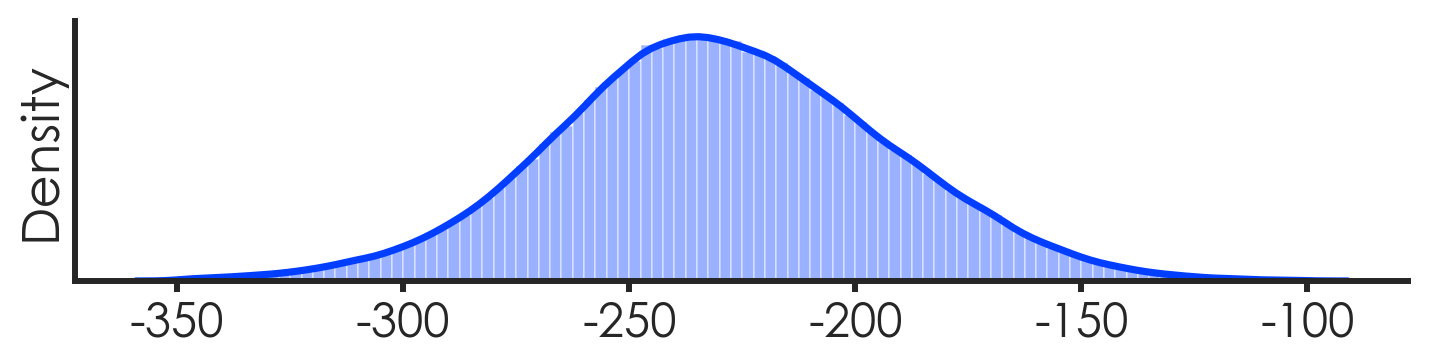

In [25]:
def in_range(a,lower_lim,upper_lim):
    return lower_lim <= a < upper_lim

n_bins=100
percentile=False
n_bits = X_all.shape[1]

sub_df = df[df[calib_label].apply(in_range,args=(-350,-100))]
if percentile:
    bins = np.percentile(sub_df[calib_label],np.linspace(0.0,100.0,n_bins+1))
else:
    bins = np.linspace(-350,-100.0,n_bins+1)

X_avg = np.zeros((n_bins,n_bits))
for i in range(n_bins):
    lower_lim, upper_lim = bins[i],bins[i+1]
    in_bin = df[calib_label].apply(in_range,args=(lower_lim,upper_lim,))
    X_avg[i,:]=np.mean(X_all[df[in_bin].index.tolist(),:],axis=0)

plt.figure(figsize=(10,2))
sns.distplot(sub_df[calib_label].values,bins=bins)
plt.ylabel('Density')
plt.yticks([])
sns.despine()
plt.savefig('Redox_dist.svg',dpi=300)
plt.show()

## rxn Heatmp

/home/beangoben/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


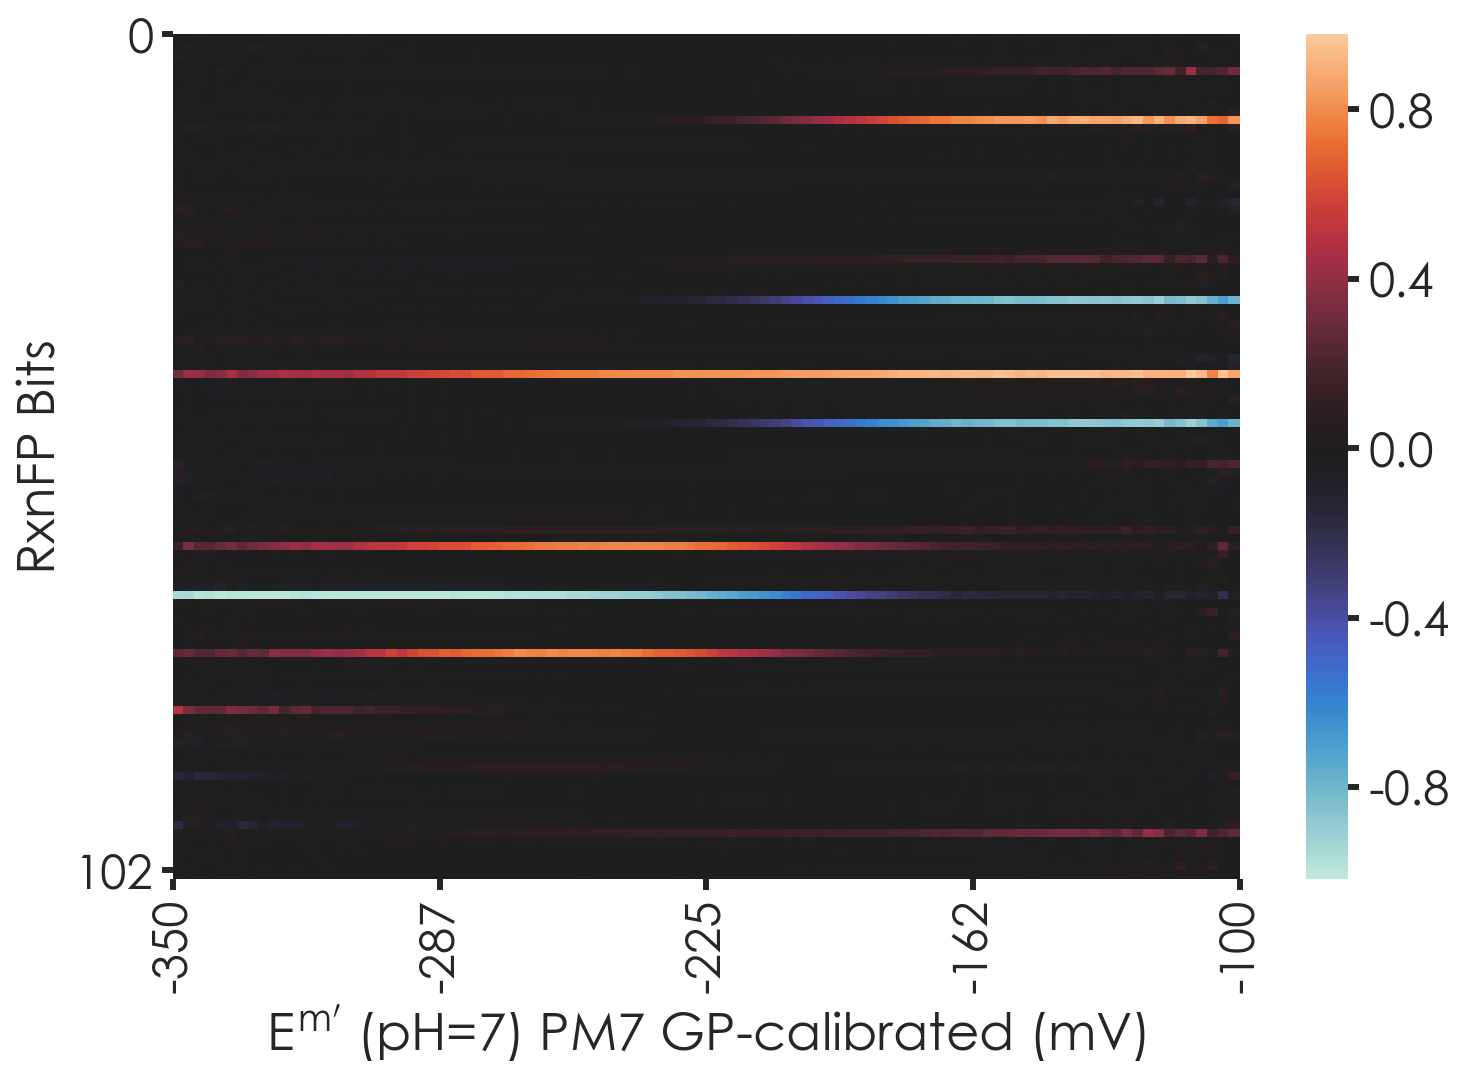

In [14]:
sns.heatmap(X_avg.T,center=0)
plt.ylabel('RxnFP Bits')
plt.yticks([0,n_bits-1],[0,n_bits-1],rotation='horizontal')

if percentile:
    plt.xlabel('Percentile (%)')
    plt.xticks(np.arange(0,101,25),np.arange(0,101,25),rotation='vertical')
else:
    plt.xlabel('$E^{{m}^\prime}$ (pH=7) PM7 GP-calibrated ($mV$)')
    value_ticks = [ int(bins[math.ceil(i*n_bins)]) for i in np.linspace(0,1,5)]
    plt.xticks(np.arange(0,101,25),value_ticks,rotation='vertical')

plt.savefig('Rxn_heatmap.svg',dpi=300)
plt.savefig('Rxn_heatmap.png',dpi=300)
plt.show()

## Utility drawing functions

In [34]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import rdkit
logger =rdkit.RDLogger.logger
logger.setLevel(logger,rdkit.RDLogger.CRITICAL)
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D

def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = rdMolDraw2D.PrepareMolForDrawing(mol,kekulize=kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

def draw_bit_highlighted(smiles_list,important_bits,rxn_dict,radius,nbits,label,col):
    html_header(label,3)
    print(label)
    for side_index,side_label in enumerate(['left','right']):
        mol = Chem.MolFromSmiles(smiles_list[side_index])
        bitinfo = {}
        AllChem.GetMorganFingerprintAsBitVect(mol, radius=6,nBits=2048, bitInfo=bitinfo,)
        bit_id = important_bits[side_index]
        bit_id_real = rxn_dict[bit_id]
        if bit_id_real in bitinfo.keys():
            aid,rad = bitinfo[bit_id_real][0]
            display(getSubstructDepiction(mol,aid,rad,col))
        else:
            display(getSubstructDepiction(mol,0,0,col))

    return

def getSubstructDepiction(mol,atomID,radius,col):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        # = None
        bondsToUse =[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
            bondsToUse.append(b)
        atomsToUse = list(set(atomsToUse))
        highlightAtomColors = {aid:col for aid in atomsToUse}
        highlightBondColors = {bid:col for bid in bondsToUse}
    else:
        atomsToUse = []
        highlightAtomColors = None
        bondsToUse=None
        highlightBondColors = None
        env=None
    return moltosvg(mol,highlightAtoms=atomsToUse,
                    highlightBonds=bondsToUse,
                    highlightAtomColors=highlightAtomColors,
                   highlightBondColors=highlightBondColors)

def draw_rxn_exmample(smiles_left,smiles_right,label):
    gpm.utils.plotting.html_header(label,3)
    mols = [Chem.MolFromSmiles(smiles_left),Chem.MolFromSmiles(smiles_right)]
    labels=['left','right']
    img = Draw.MolsToImage(mols,legends=labels)
    return img

def draw_bit_examples(smiles_list,important_bits,rxn_dict,radius,nbits):
    useful_info =[]
    labels=[]
    # Left side
    for side_index,side_label in enumerate(['left','right']):
        mol = Chem.MolFromSmiles(smiles_list[side_index])
        bitinfo = {}
        AllChem.GetMorganFingerprintAsBitVect(mol, radius=6,nBits=2048, bitInfo=bitinfo,)
        for bit_id in important_bits[side_index]:
            bit_id_real = rxn_dict[bit_id]
            if bit_id_real in bitinfo.keys():
                useful_info.append((mol,bit_id_real,bitinfo))
                labels.append('RxnBit {} - {}'.format(side_label, bit_id))
            
    gpm.utils.plotting.html_header('bit environments',4)
    img = Draw.DrawMorganBits(useful_info,legends=labels)
    return img

## Calculate 'interesting' bits
Bits that have some long range pattern.

In [24]:
## Create map bit indices from rxn reduced fingerprints to normal fingerprints
rxn_feature = gp.preprocessor.features[0]
nbits = rxn_feature.meta_data['fp_args']['nBits']
radius = rxn_feature.meta_data['fp_args']['radius']
rxnbit_to_fpbit={}
count=0
for index,value in enumerate(rxn_feature.mask_dim):
    if value:
        rxnbit_to_fpbit[count]=index
        count+=1
# Print bits 
tol = 0.1
all_bits=[]

bits_per_bins=OrderedDict()
for bin_index in range(n_bins):
    bin_average = X_avg[bin_index,:]
    lower_lim, upper_lim = bins[bin_index],bins[bin_index+1]
    in_bin = df[calib_label].apply(in_range,args=(lower_lim,upper_lim,))
    sub_df = df[in_bin]
    X_chunk = np.mean(X_all[df[in_bin].index.tolist(),:],axis=0)
    important_bits = np.arange(0,n_bits)[np.abs(bin_average)>= tol]
    bits_per_bins[bin_index] = important_bits
    all_bits = all_bits + list(important_bits)

print('All',sorted(list(set(all_bits))))
print('Starting bits: {}'.format(bits_per_bins[0]))
last_bin=0
example_info = []
maybe_bits=[]
for bin_index in range(n_bins-1):
    start_bits = bits_per_bins[bin_index]
    end_bits = bits_per_bins[bin_index+1]
    lose_bits = list(set(start_bits).difference(set(end_bits)))
    gain_bits = list(set(end_bits).difference(set(start_bits)))
    maybe_bits = maybe_bits + lose_bits
    maybe_bits = maybe_bits + gain_bits
    if len(gain_bits) > 0 or len(lose_bits) > 0:
        start_bin_range = list(set([last_bin,bin_index]))
        print('{} -> {} // Gain: {} // Lose: {}'.format(str(start_bin_range),bin_index+1,gain_bits,lose_bits))
        example_info.append({'start_bin':start_bin_range,'end_bin':bin_index+1,'gain':gain_bits,'lose':lose_bits})
        last_bin = bin_index + 1
print('Ending bits: {}'.format(bits_per_bins[n_bins-1]))
    
interest_bits = sorted(list(set(maybe_bits)))
print('Interesting bits: {}'.format(interest_bits))

All [4, 10, 27, 32, 41, 47, 52, 60, 62, 68, 75, 82, 90, 96, 97]
Starting bits: [41 62 68 75 82 90 96]
[0] -> 1 // Gain: [] // Lose: [96, 90]
[1] -> 2 // Gain: [] // Lose: [82]
[2, 3] -> 4 // Gain: [97] // Lose: []
[4] -> 5 // Gain: [32, 10, 47] // Lose: []
[5, 6] -> 7 // Gain: [27, 60] // Lose: [75]
[7] -> 8 // Gain: [4] // Lose: [62]
[8] -> 9 // Gain: [52] // Lose: [60]
Ending bits: [ 4 10 27 32 41 47 52 68 97]
Interesting bits: [4, 10, 27, 32, 47, 52, 60, 62, 75, 82, 90, 96, 97]


## Hightlight bit structures

In [ ]:
n_examples=2
interesting_bits=[4, 10, 27, 32, 47, 52, 60, 62, 75, 82, 90, 96, 97]
cols = {bit:c for bit,c in zip(interest_bits,sns.color_palette('Set2',len(interest_bits)))}
for bit in interest_bits:
    has_bit = np.abs(X_all[:,bit])>tol
    sub_df = df[has_bit].sample(n=n_examples)
    y_vals = df[has_bit][calib_label].values
    gpm.utils.plotting.html_header('Bit {}'.format(bit))
    print('Bit {}'.format(bit))
    gpm.utils.plotting.html_header('value range {:.2f} ({:.2f})'.format(np.mean(y_vals),np.std(y_vals)),2)
    print('value range {:.2f} ({:.2f})'.format(np.mean(y_vals),np.std(y_vals)))
    for _,row in sub_df.iterrows():
        draw_bit_highlighted([row['smiles_l'],row['smiles_r']],
                                  [bit,bit],
                                  rxnbit_to_fpbit,radius,nbits,row['rxn_ID'],col=cols[bit])

## Heatmap with interesting bits

/home/beangoben/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


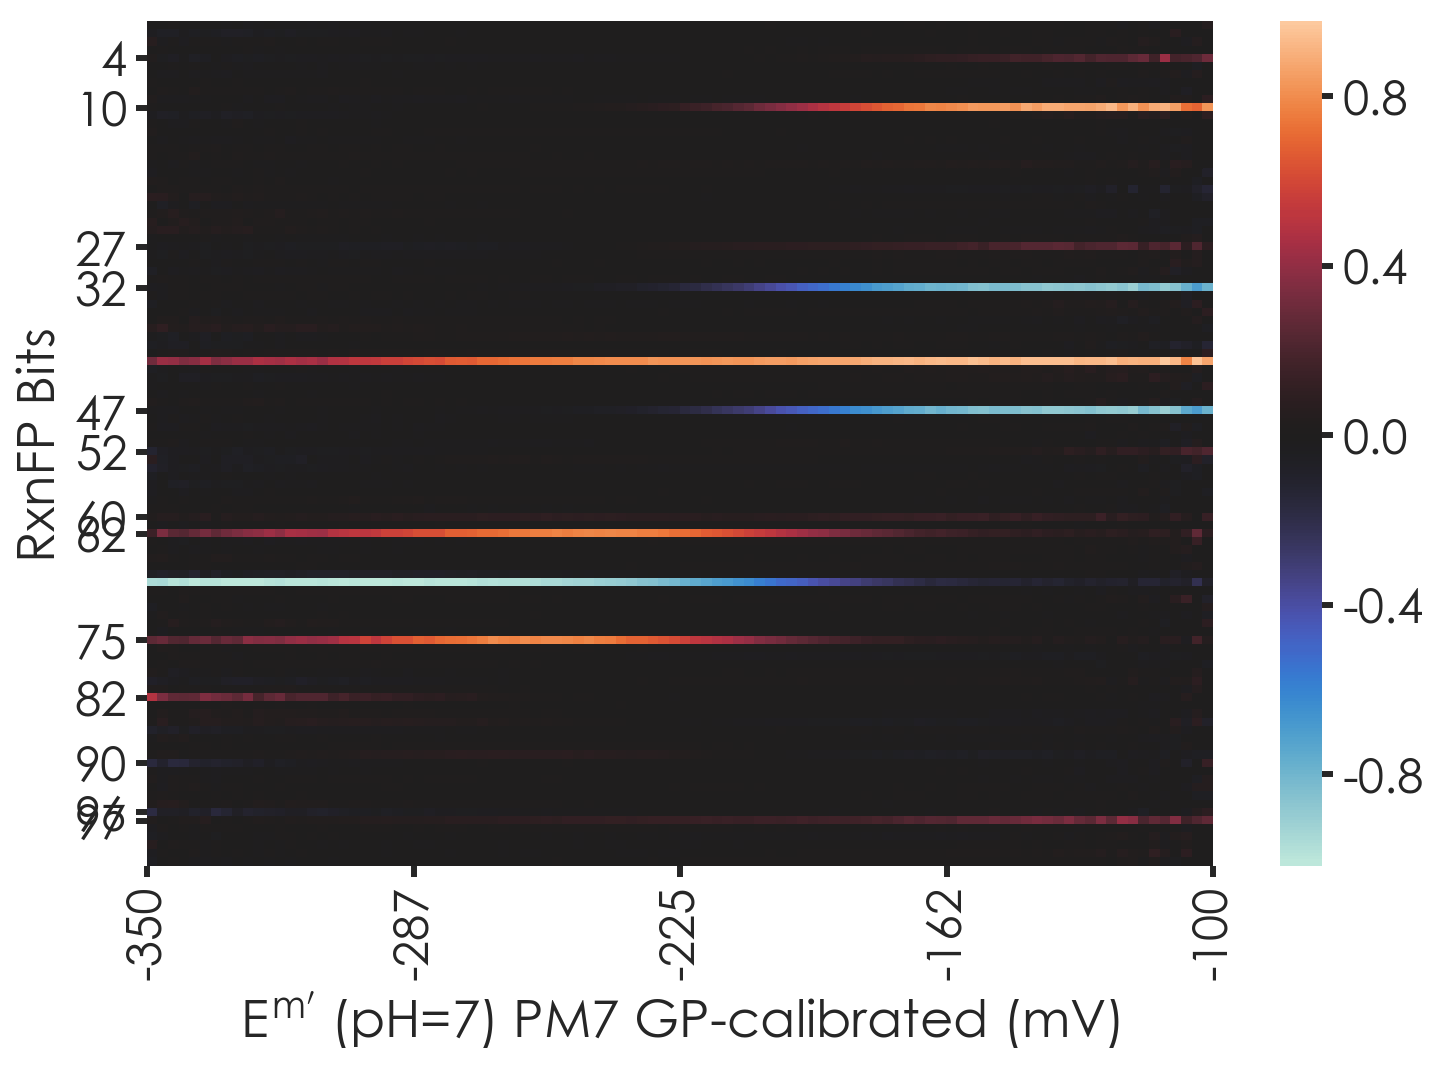

In [38]:
#plt.figure(figsize=(8,8))
sns.heatmap(X_avg.T,center=0)
plt.ylabel('RxnFP Bits')
plt.yticks(np.array(interest_bits)+0.5,interest_bits,rotation='horizontal')
#plt.yticks(np.array(interest_bits)+0.5,['' for _ in interest_bits],rotation='horizontal')

if percentile:
    plt.xlabel('Percentile (%)')
    plt.xticks(np.arange(0,101,25),np.arange(0,101,25),rotation='vertical')
else:
    plt.xlabel('$E^{{m}^\prime}$ (pH=7) PM7 GP-calibrated ($mV$)')
    value_ticks = [ int(bins[math.ceil(i*n_bins)]) for i in np.linspace(0,1,5)]
    plt.xticks(np.arange(0,101,25),value_ticks,rotation='vertical')

#plt.savefig('Rxn_heatmap.svg',dpi=300)
#plt.savefig('Rxn_heatmap.png',dpi=300)
plt.show()

In [43]:
interest_bits

[4, 10, 27, 32, 47, 52, 60, 62, 75, 82, 90, 96, 97]

Bit 4


value range -220.75 (62.97)


Z49645 = Z28888


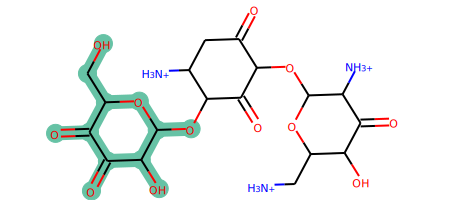

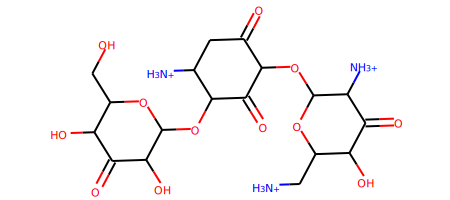

Z27989 = Z45094


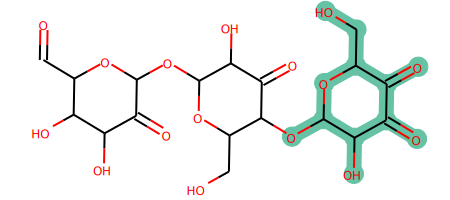

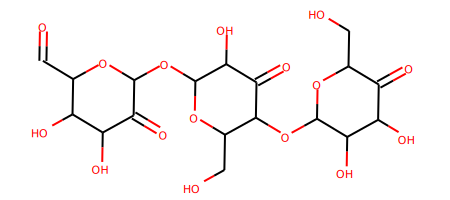

Bit 52


value range -191.43 (1770.08)


Z61179 = Z64631


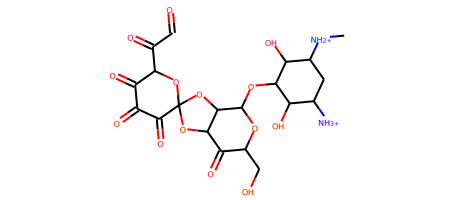

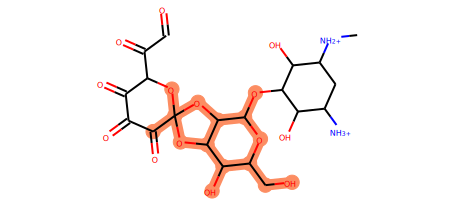

Z66581 = Z61068


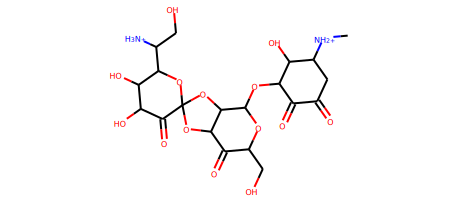

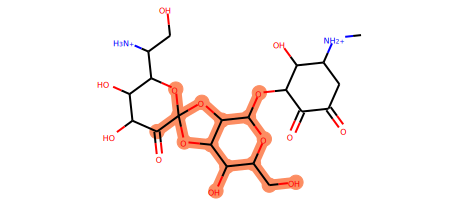

Bit 75


value range -241.39 (63.11)


Z36500 = Z46928


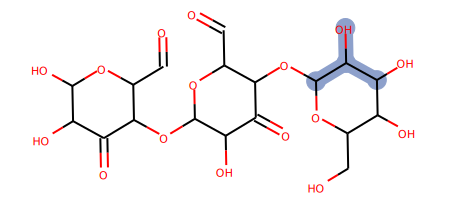

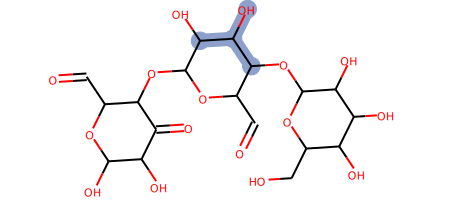

Z31316 = Z43753


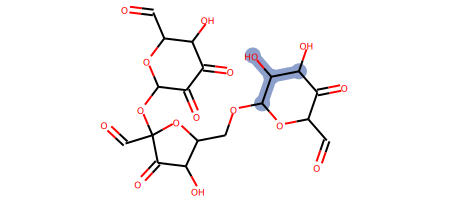

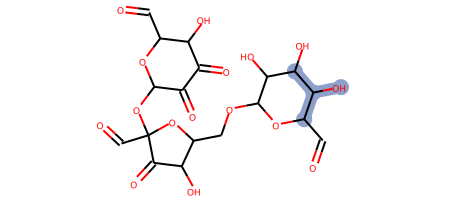

Bit 82


value range -248.22 (74.44)


Z45635 + C00014 = Z33398 + C00001


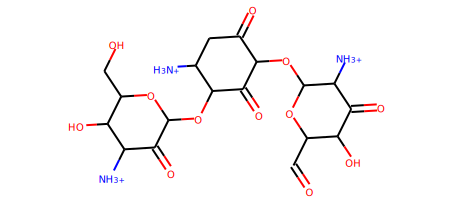

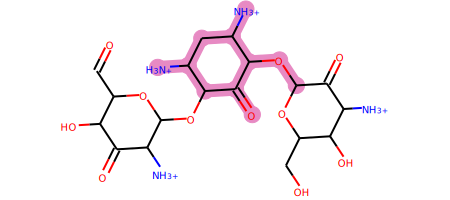

Z68701 + C00014 = Z67234 + C00001


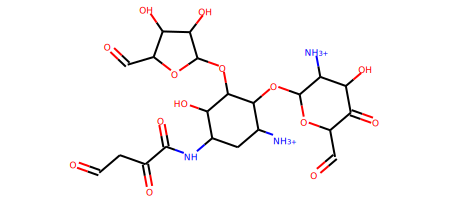

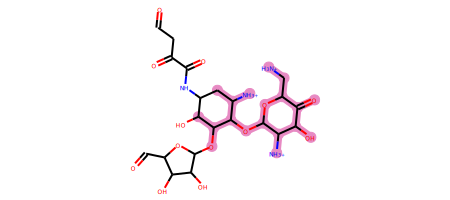

In [48]:
n_examples=2
local_bits=[ 4, 52,  75, 82]
cols = {bit:c for bit,c in zip(local_bits,sns.color_palette('Set2',len(local_bits)))}
for bit in local_bits:
    has_bit = np.abs(X_all[:,bit])>tol
    sub_df = df[has_bit].sample(n=n_examples)
    y_vals = df[has_bit][calib_label].values
    gpm.utils.plotting.html_header('Bit {}'.format(bit))
    print('Bit {}'.format(bit))
    gpm.utils.plotting.html_header('value range {:.2f} ({:.2f})'.format(np.mean(y_vals),np.std(y_vals)),2)
    print('value range {:.2f} ({:.2f})'.format(np.mean(y_vals),np.std(y_vals)))
    for _,row in sub_df.iterrows():
        draw_bit_highlighted([row['smiles_l'],row['smiles_r']],
                                  [bit,bit],
                                  rxnbit_to_fpbit,radius,nbits,row['rxn_ID'],col=cols[bit])